# Entrenamiento de modelos de segmentación
Este cuaderno entrena modelos U-Net con encoder ResNet34 usando el dataset NHANES II.  
Se entrena un modelo general, así como modelos especializados para la región lumbar y cervical.  
Las imágenes se encuentran preprocesadas en formato `.png`, organizadas por región y tipo (imagen / máscara).


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import EarlyStopping

import cv2
import numpy as np
from PIL import Image
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob

import shutil

from datetime import datetime

In [10]:
TARGET_CLASS = 'vertebra'
PROCESSED_DATASET_PATH = 'dataset_procesado'
DATASET_PATH = os.path.join(PROCESSED_DATASET_PATH, 'dataset_con_mascara') 
NEW_DATA_PATH = os.path.join(PROCESSED_DATASET_PATH, 'dataset_sin_mascara')
RESULTS_DIR = os.path.join(PROCESSED_DATASET_PATH, 'Results')

ARCH = "Unet" # "FPN" "Unet"
ENCODER = 'resnet34' # 'resnet34' 'vgg16'
MAX_EPOCHS = 77 # probado con 40 y 77
BATCH_SIZE = 16
TRAIN_SIZE = 0.7
VAL_SIZE = 0.2

In [11]:
# Pipeline de augmentation
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

# Pipeline de preprocessing (transformaciones fijas)
preprocessing = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

transform = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
])

c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\albumentations\core\validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
class SpineDataset(Dataset):

    CLASSES = ['_background_', 'vertebra']

    def __init__(
            self,
            images_dir,
            masks_dir, 
            target_class='vertebra',
            augmentation=augmentation,
            preprocessing=preprocessing,
            transform=None,
            mode = 'train'
    ):
        self.ids = os.listdir(images_dir)
        self.mode = mode
        random.seed(42)
        # Shuffle the data
        data_copy = self.ids[:]
        data_copy.sort()
        random.shuffle(data_copy)
        # Determine the split indices
        total_len = len(data_copy)
        train_size = TRAIN_SIZE
        val_size = VAL_SIZE
        train_end = int(total_len * train_size)
        val_end = train_end + int(total_len * val_size)
        # Split the data
        if mode == 'train':
          self.ids = data_copy[:train_end]
        elif mode == 'val':
          self.ids = data_copy[train_end:val_end]
        else:
          self.ids = data_copy[val_end:]

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_value = self.CLASSES.index(target_class.lower())
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transform = transform

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_fps[i], 0)
        mask = mask.squeeze()
        mask = mask.astype(np.float32)
        mask[mask != self.class_value] = 0.0
        mask[mask == self.class_value] = 1.0

        image = np.array(Image.fromarray(image).resize((512, 512), Image.BILINEAR))
        mask = np.array(Image.fromarray(mask).resize((512, 512), Image.NEAREST))

        if self.mode == 'train' and self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = np.moveaxis(image, -1, 0)
        mask = np.expand_dims(mask, 0)

        return {"image": image,"mask" : mask}

    def __len__(self):
        return len(self.ids)

## Definición del modelo y función de pérdida
Se utiliza la arquitectura U-Net con encoder ResNet34 y función de pérdida Dice Loss.  
El entrenamiento se realiza con PyTorch Lightning.

In [13]:
class SpineModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes, **kwargs):
        super().__init__()
        self.train_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, encoder_weights = encoder_weights, in_channels=in_channels, classes=out_classes, **kwargs
        )
        self.save_hyperparameters()
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        device = next(self.model.parameters()).device  # get model device
        image = image.to(device)
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        output= {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }
        if stage == "train":
          self.train_step_outputs.append(output)
        elif stage == "test":
          self.test_step_outputs.append(output)
        else:
          self.valid_step_outputs.append(output)

        return output

    def shared_epoch_end(self, stage):
        # aggregate step metics
        if stage == "train":
          outputs = self.train_step_outputs
        elif stage == "test":
          outputs = self.test_step_outputs
        else:
          outputs = self.valid_step_outputs

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        if stage == "train":
          self.train_step_outputs.clear()  # free memory
        elif stage == "test":
          self.test_step_outputs.clear()  # free memory
        else:
          self.valid_step_outputs.clear()  # free memory

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [14]:
def encontrar_archivo_mas_reciente(directorio, extension='.ckpt'):
    archivos = glob.glob(os.path.join(directorio, '**', f'*{extension}'), recursive=True)
    if not archivos:
        return None
    return max(archivos, key=os.path.getmtime)

### Definición de funciones auxiliares

In [15]:
def preparar_datos(region = "general"):
  """
    Crea el dataset general o carga solo la región especificada
  """
  if region == 'general':
    temp_dir = os.path.join(DATASET_PATH, "general")
    images_dir = os.path.join(temp_dir, 'imagenes')
    masks_dir = os.path.join(temp_dir, 'mascaras')

    if os.path.exists(temp_dir):
      shutil.rmtree(temp_dir) # Eliminar el directorio temporal si existe

    os.makedirs(images_dir)
    os.makedirs(masks_dir)

    for subregion in os.listdir(DATASET_PATH):
      if subregion == 'general':
        continue
      img_src = os.path.join(DATASET_PATH, subregion, 'imagenes')
      mask_src = os.path.join(DATASET_PATH, subregion, 'mascaras')

      for image in os.listdir(img_src):
        shutil.copy(os.path.join(img_src, image), images_dir)
      for mask in os.listdir(mask_src):
        shutil.copy(os.path.join(mask_src, mask), masks_dir)

  else:
    images_dir = os.path.join(DATASET_PATH, region, 'imagenes')
    masks_dir = os.path.join(DATASET_PATH, region, 'mascaras')

  return images_dir, masks_dir


In [16]:
def entrenar_modelo(region="general"):
    """
    Entrena el modelo usando los datos preparados de la región especificada.
    """
    images_dir, masks_dir = preparar_datos(region)
    model_results_dir = os.path.join(RESULTS_DIR, region)
    os.makedirs(model_results_dir, exist_ok=True)

    # Se divide el dataset en entrenamiento, validación y testeo
    train_dataset = SpineDataset(images_dir, masks_dir, target_class=TARGET_CLASS, transform = transform, mode='train')
    val_dataset = SpineDataset(images_dir, masks_dir, target_class=TARGET_CLASS, mode='val')
    test_dataset = SpineDataset(images_dir, masks_dir, target_class=TARGET_CLASS, mode='test')

    # Borrar
    test_save_dir = os.path.join('test', region)
    test_images_dir = os.path.join(test_save_dir, 'imagenes')
    test_masks_dir = os.path.join(test_save_dir, 'mascaras')
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_masks_dir, exist_ok=True)
    for img_name in test_dataset.ids:
        shutil.copy(os.path.join(images_dir, img_name), test_images_dir)
        shutil.copy(os.path.join(masks_dir, img_name), test_masks_dir)
    # Hasta aquí

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f'Tamaño del conjunto de entrenamiento: {len(train_loader.dataset)}')
    print(f'Tamaño del conjunto de validación: {len(val_loader.dataset)}')
    print(f'Tamaño del conjunto de testeo: {len(test_loader.dataset)}')

    assert set(test_dataset.ids).isdisjoint(set(train_dataset.ids))
    assert set(test_dataset.ids).isdisjoint(set(val_dataset.ids))
    assert set(train_dataset.ids).isdisjoint(set(val_dataset.ids))

    # Se crea la carpeta para guardar los resultados
    now = datetime.now()
    date_result_dir = os.path.join(model_results_dir, now.strftime("%Y-%m-%d_%H-%M-%S"))
    os.makedirs(date_result_dir, exist_ok=True)

    ckpt_path = encontrar_archivo_mas_reciente(model_results_dir)

    model = SpineModel(ARCH, ENCODER, encoder_weights='imagenet', in_channels=3, out_classes=1)

    early_stop_callback = EarlyStopping(
        monitor='valid_per_image_iou',
        patience=15, 
        verbose=True,
        mode='min'
    )

    trainer = pl.Trainer(
        callbacks=[early_stop_callback],
        max_epochs=MAX_EPOCHS,
        default_root_dir=date_result_dir
    )

    if ckpt_path:
        trainer.fit(model, ckpt_path=ckpt_path, train_dataloaders=train_loader, val_dataloaders=val_loader)
    else:
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
    pprint(valid_metrics)

    test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
    pprint(test_metrics)

    results_file_path = os.path.join(date_result_dir, 'IoU.txt')
    with open(results_file_path, 'w') as f:
        f.write(f"Región: {region}\n")
        f.write(f"Arquitectura: {ARCH}\n")
        f.write(f"Encoder: {ENCODER}\n")
        for clave, valor in valid_metrics[0].items():
            f.write(f"{clave}: {valor}\n")
        for clave, valor in test_metrics[0].items():
            f.write(f"{clave}: {valor}\n")
    
    results_images_path = os.path.join(date_result_dir, 'Test Images')
    if not os.path.exists(results_images_path):
        os.makedirs(results_images_path)
    
    bath = next(iter(test_loader))
    with torch.no_grad():
        model.eval()
        logits = model(bath['image'])
    pr_masks = logits.sigmoid()

    cont = 1
    for image, gt_mask, pr_mask in zip(bath['image'], bath['mask'], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())  # squeeze the mask
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())  # squeeze the prediction
        plt.title("Prediction")
        plt.axis("off")

        plt.savefig(os.path.join(results_images_path, 'images_' + str(cont) + '.png'))
        plt.show()
        cont += 1

### Entrenamiento del modelo
Se monitoriza la cantidad de imágenes por conjunto y las métricas IoU. 
#### Modelo general

Tamaño del conjunto de entrenamiento: 380
Tamaño del conjunto de validación: 108
Tamaño del conjunto de testeo: 55


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at dataset_procesado\Results\general\2025-03-29_11-19-45\lightning_logs\version_0\checkpoints\epoch=76-step=1848.ckpt
c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:362: The dirpath has changed from 'dataset_procesado\\Results\\general\\2025-03-29_11-19-45\\lightning_logs\\version_0\\checkpoints' to 'dataset_procesado\\Results\\general\\2025-06-12_13-08-21\\lightning_logs\\version_0\\checkpoints', therefore

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=77` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_dataset_iou': 0.81669020652771,
  'valid_per_image_iou': 0.8179343938827515}]


c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_dataset_iou': 0.8216423988342285,
  'test_per_image_iou': 0.822702944278717}]


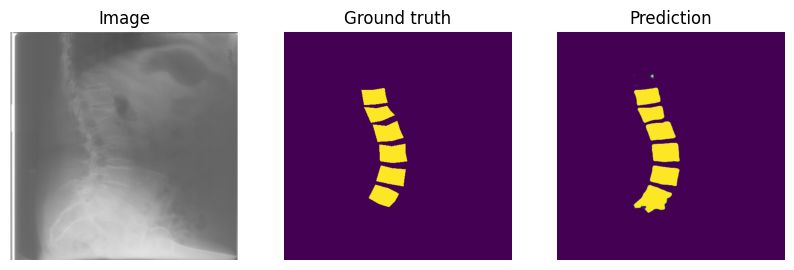

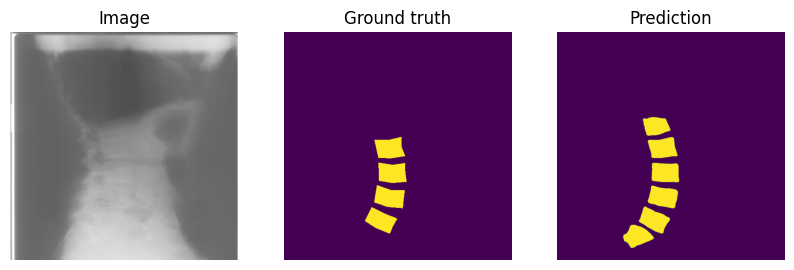

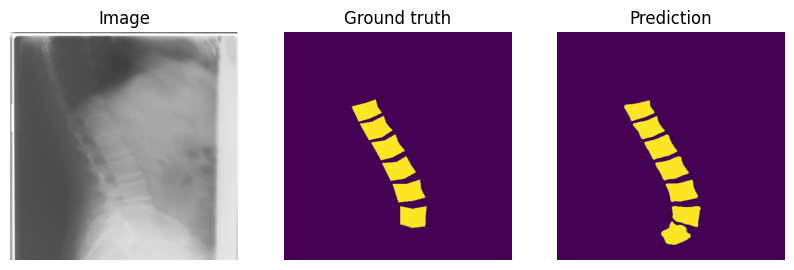

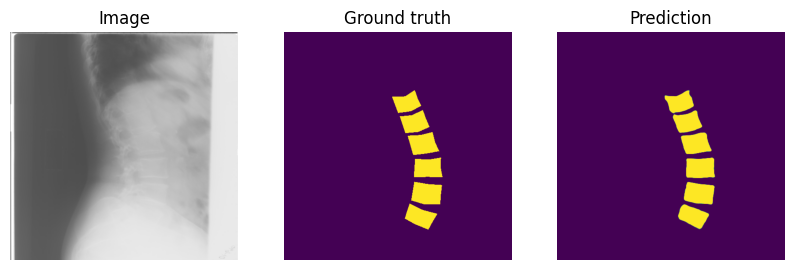

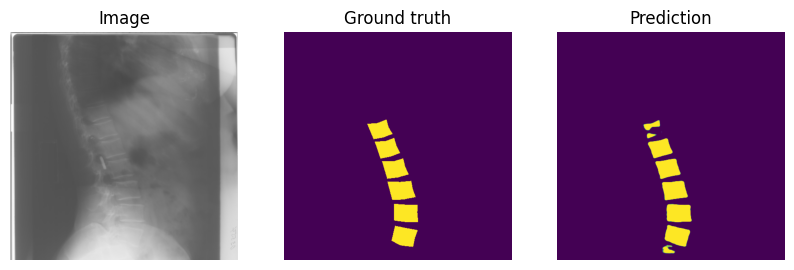

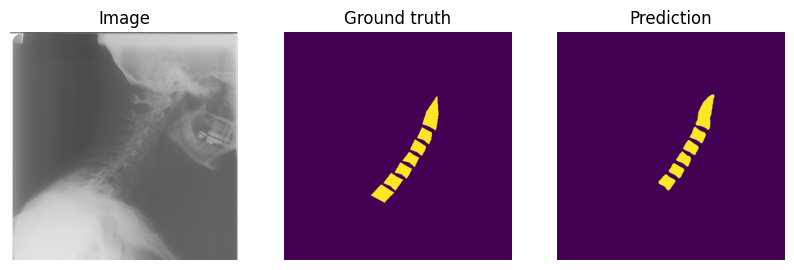

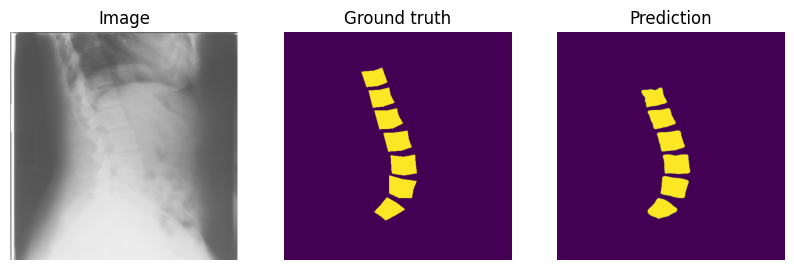

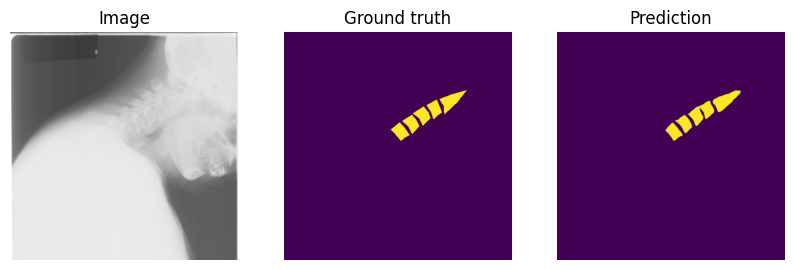

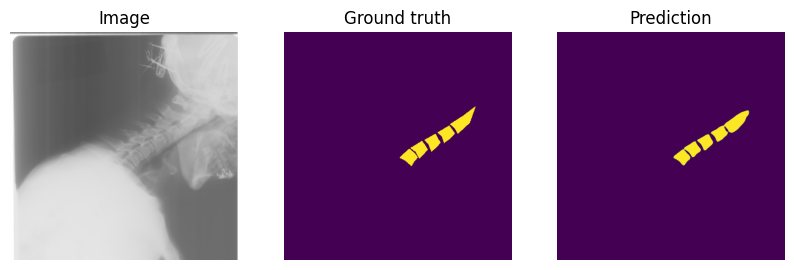

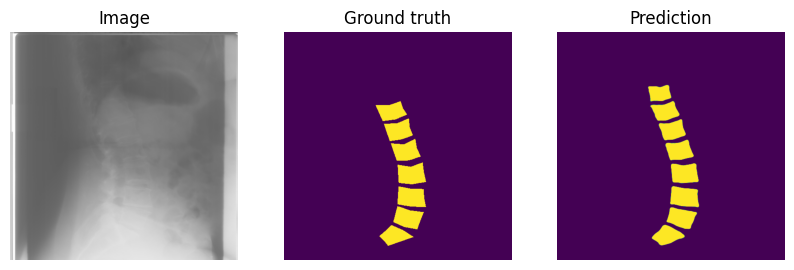

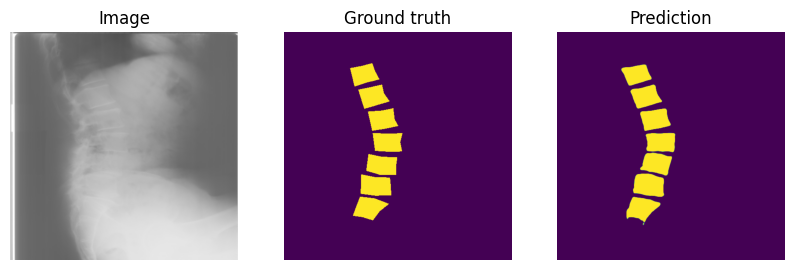

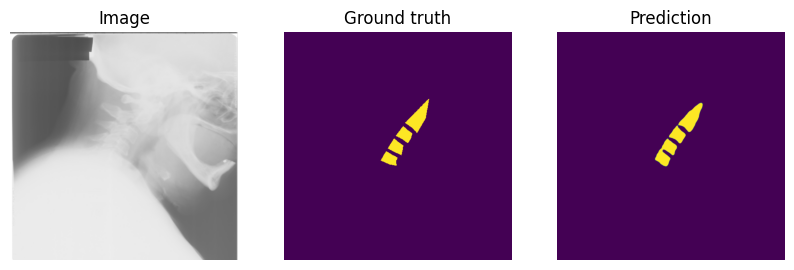

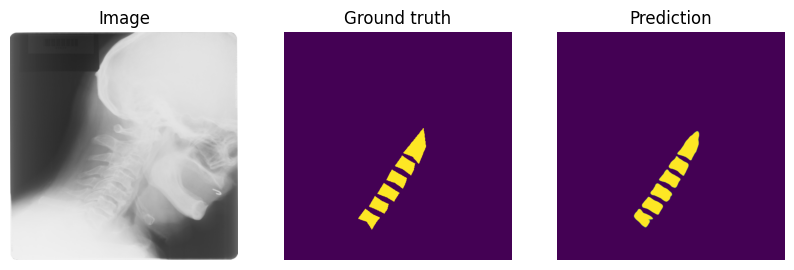

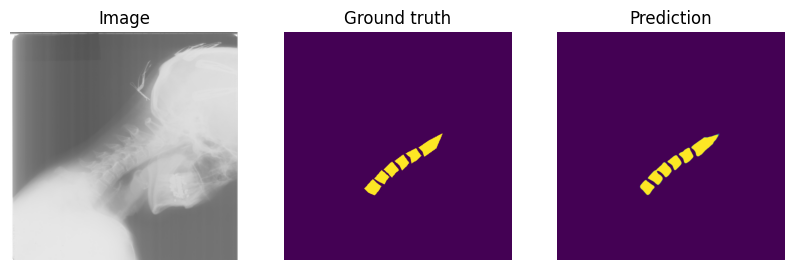

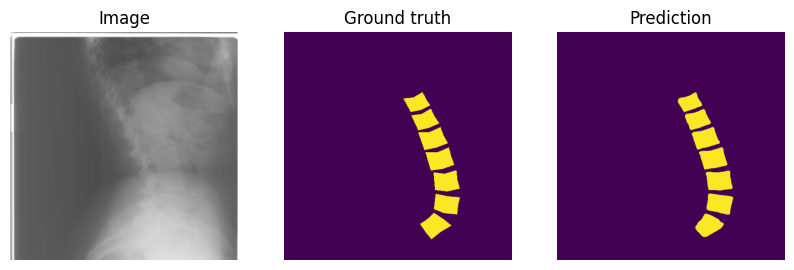

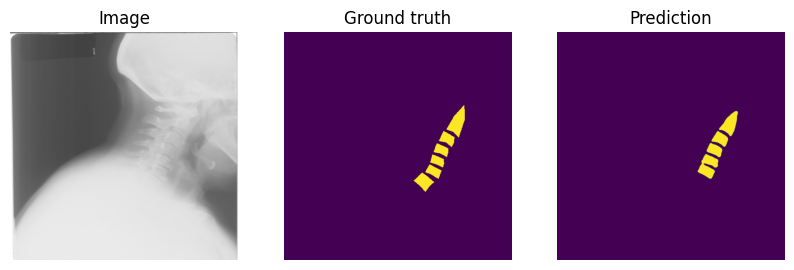

In [17]:
entrenar_modelo("general")

#### Modelo cervical

Tamaño del conjunto de entrenamiento: 192
Tamaño del conjunto de validación: 55
Tamaño del conjunto de testeo: 28


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at dataset_procesado\Results\cervical\2025-03-23_18-49-57\lightning_logs\version_0\checkpoints\epoch=61-step=744.ckpt
c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:362: The dirpath has changed from 'dataset_procesado\\Results\\cervical\\2025-03-23_18-49-57\\lightning_logs\\version_0\\checkpoints' to 'dataset_procesado\\Results\\cervical\\2025-06-12_12-57-38\\lightning_logs\\version_0\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 24.4 M | train
1 | loss_fn | DiceLoss | 0      | train
---------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=62` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_dataset_iou': 0.8448789715766907,
  'valid_per_image_iou': 0.8459725379943848}]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_dataset_iou': 0.8099177479743958,
  'test_per_image_iou': 0.8115360736846924}]


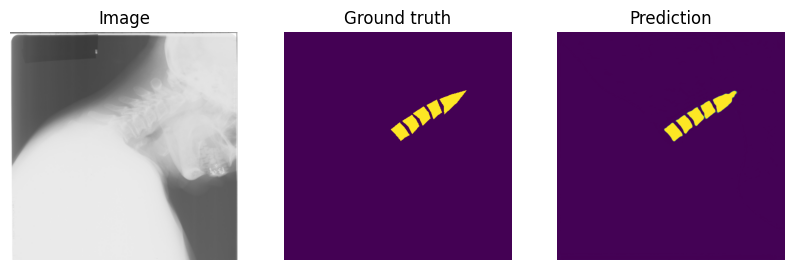

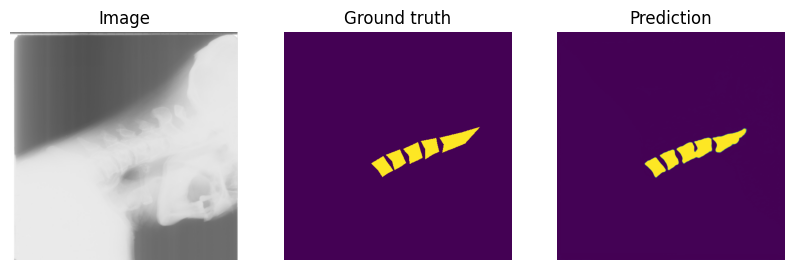

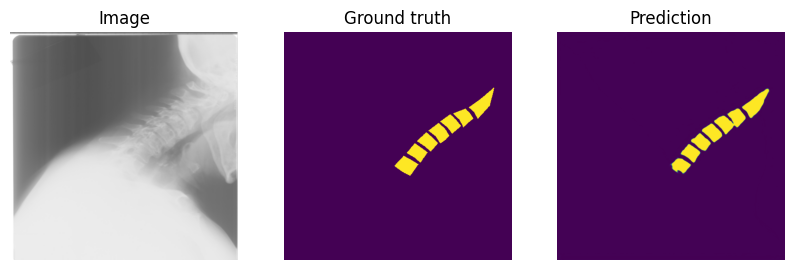

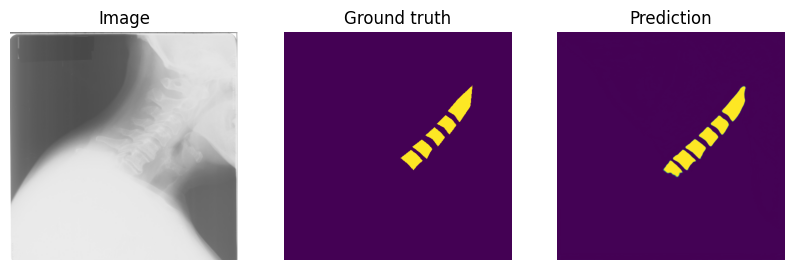

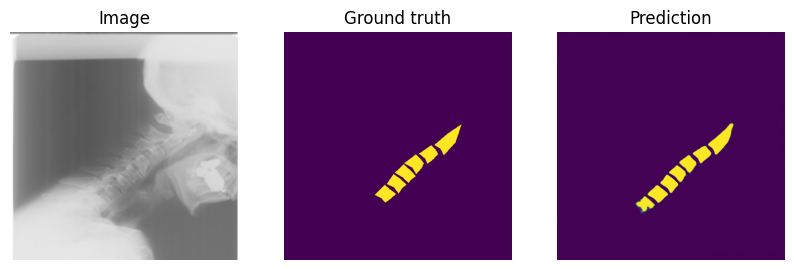

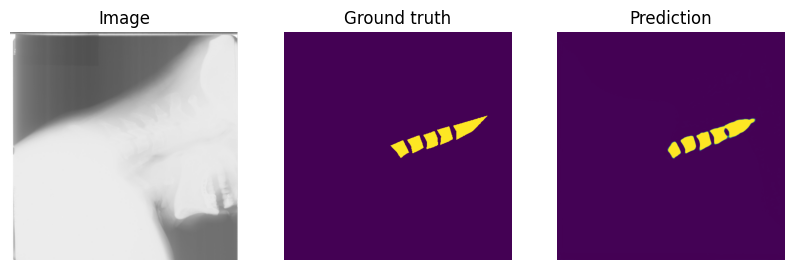

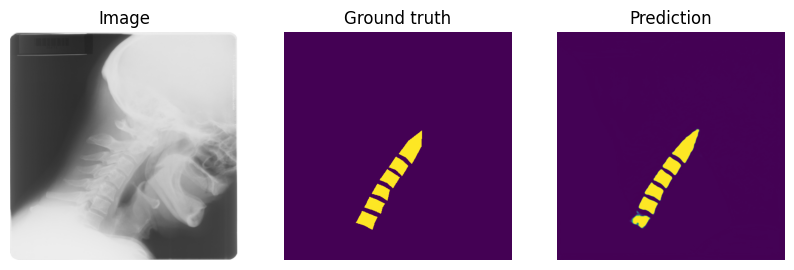

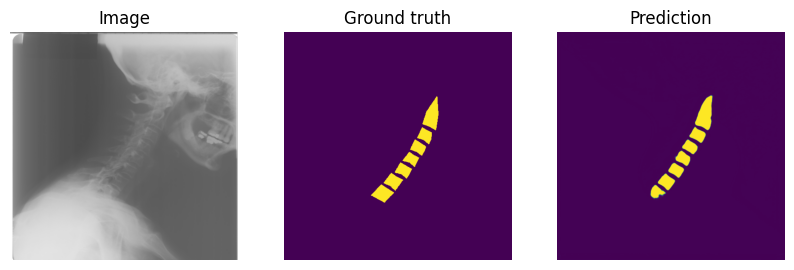

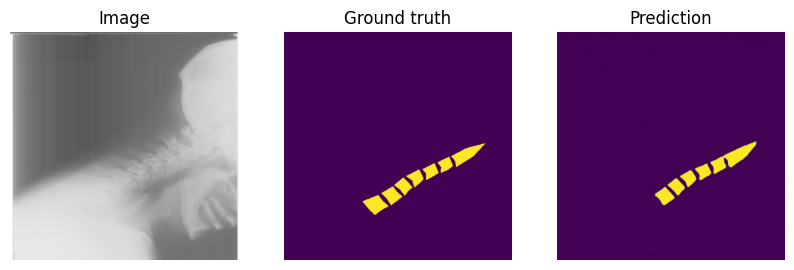

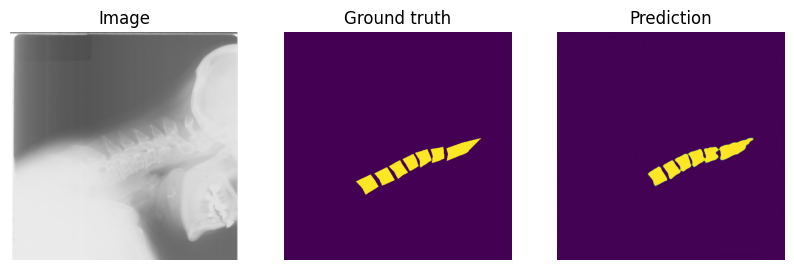

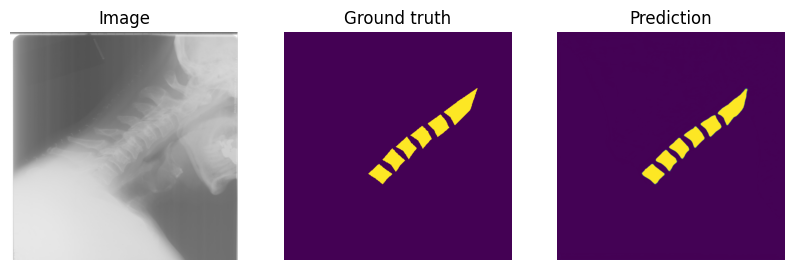

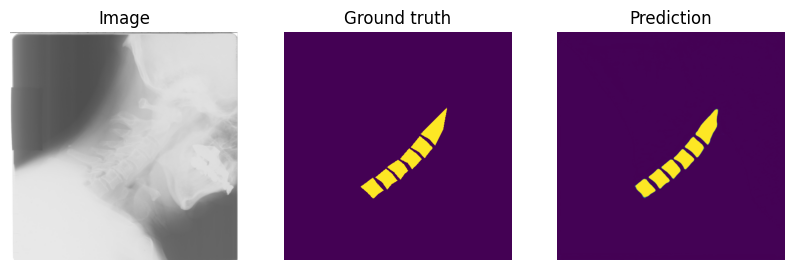

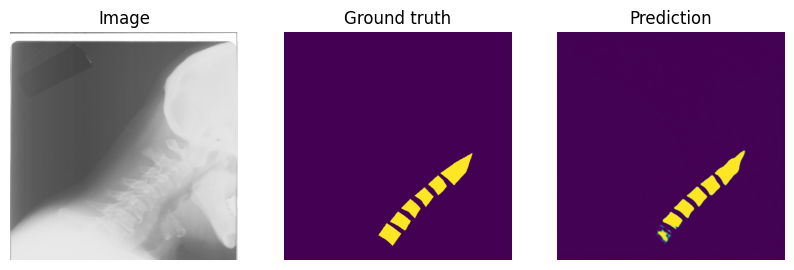

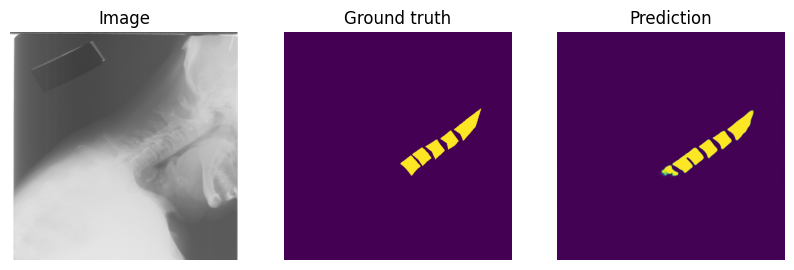

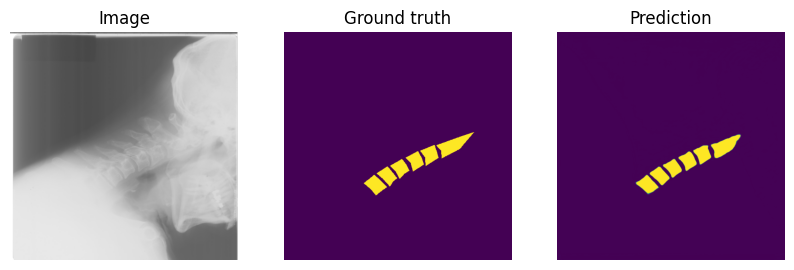

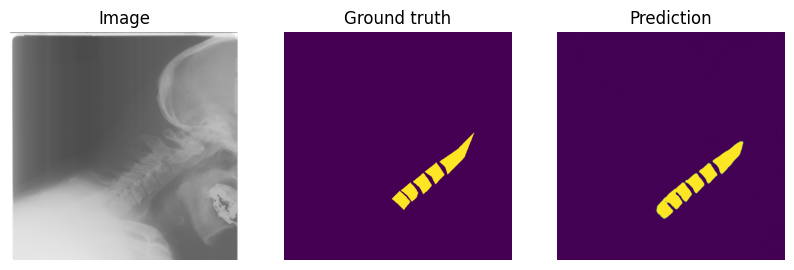

In [28]:
entrenar_modelo("cervical")

Tamaño del conjunto de entrenamiento: 187
Tamaño del conjunto de validación: 53
Tamaño del conjunto de testeo: 28


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at dataset_procesado\Results\lumbar\2025-03-23_18-38-15\lightning_logs\version_0\checkpoints\epoch=60-step=732.ckpt
c:\Users\tania\miniconda3\envs\tf_gpu\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:362: The dirpath has changed from 'dataset_procesado\\Results\\lumbar\\2025-03-23_18-38-15\\lightning_logs\\version_0\\checkpoints' to 'dataset_procesado\\Results\\lumbar\\2025-06-12_13-00-27\\lightning_logs\\version_0\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 24.4 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=61` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_dataset_iou': 0.7995420098304749,
  'valid_per_image_iou': 0.8008707165718079}]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_dataset_iou': 0.8223550319671631,
  'test_per_image_iou': 0.8244084119796753}]


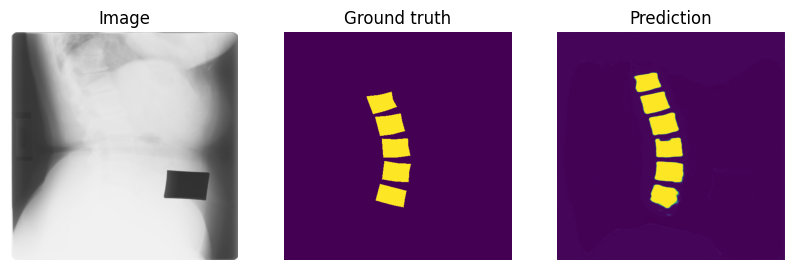

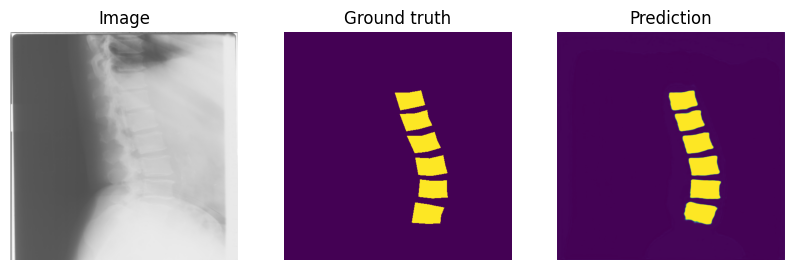

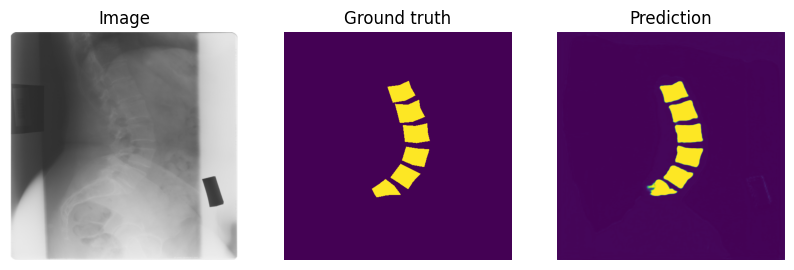

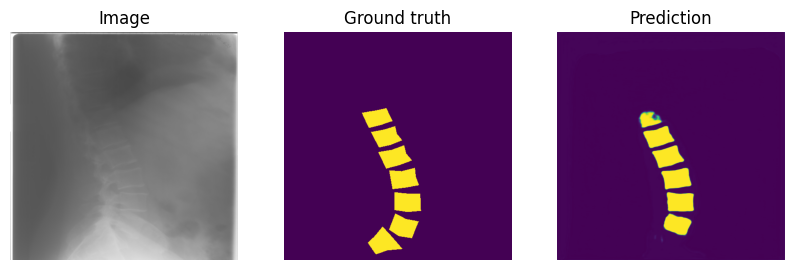

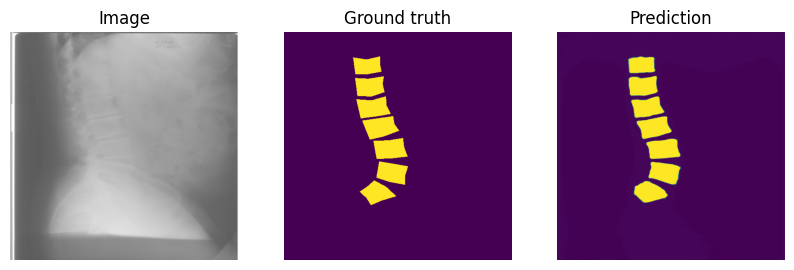

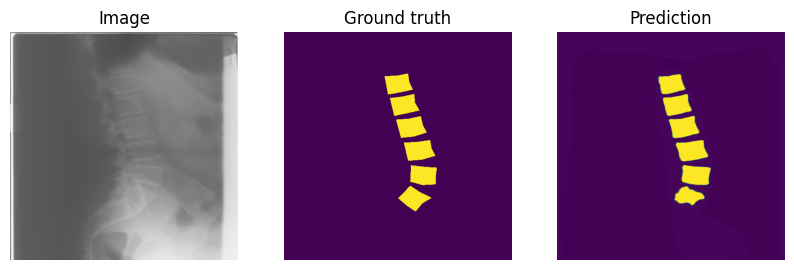

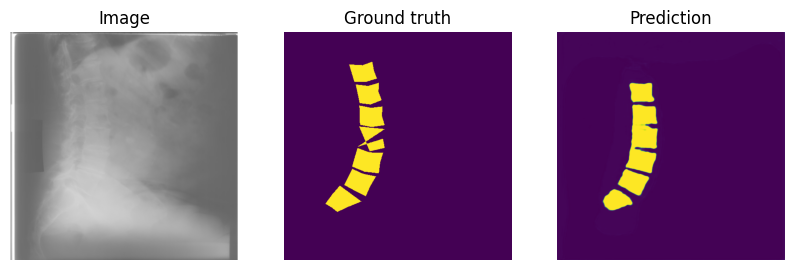

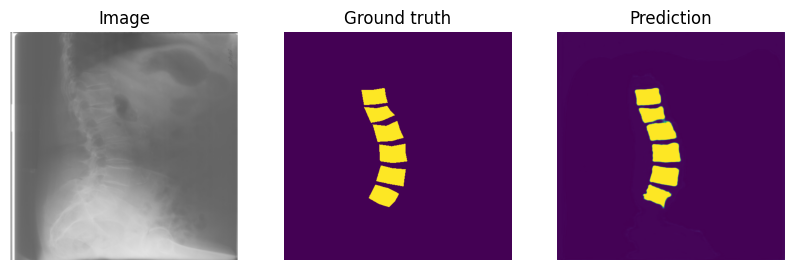

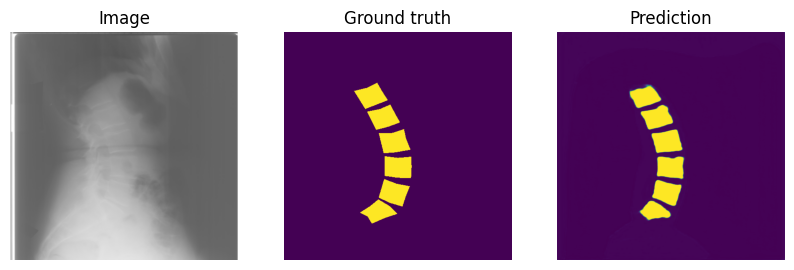

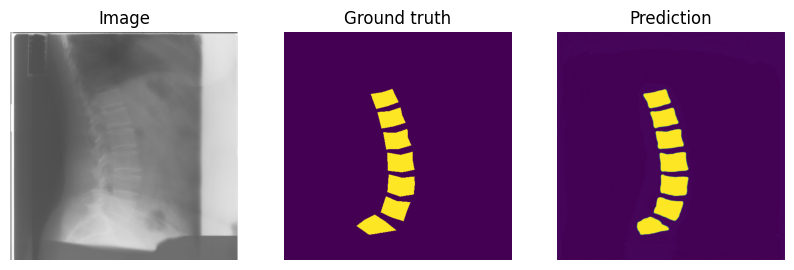

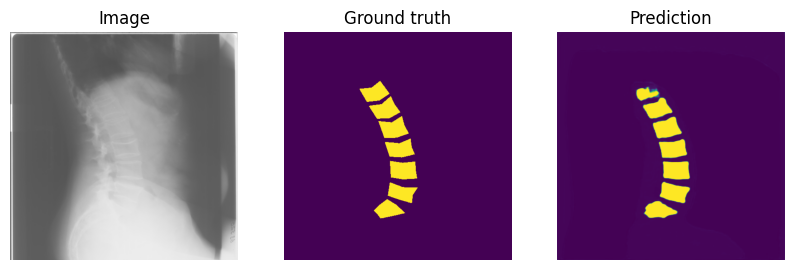

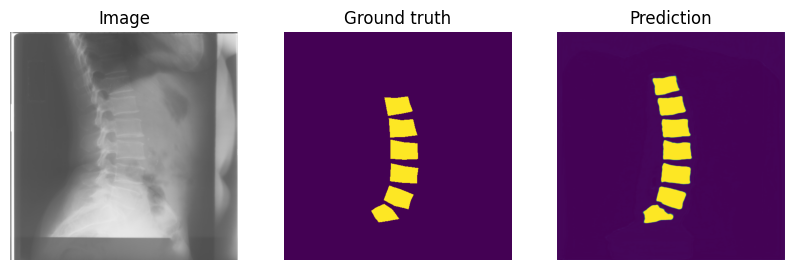

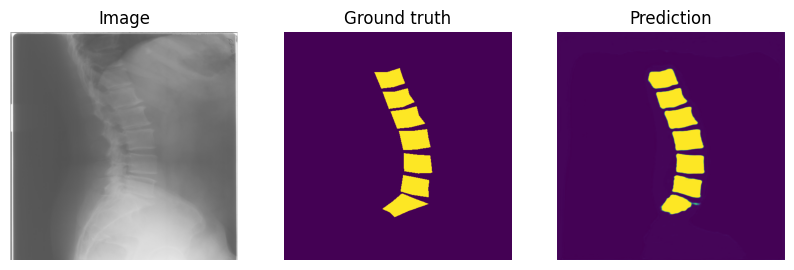

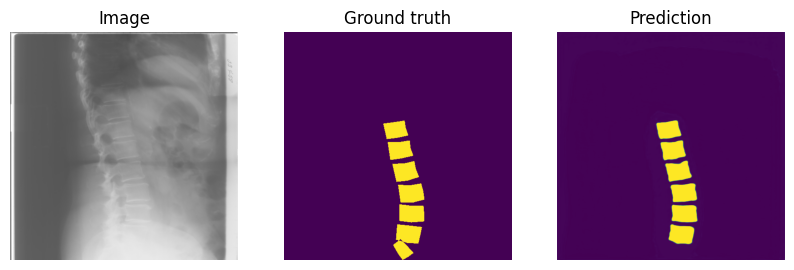

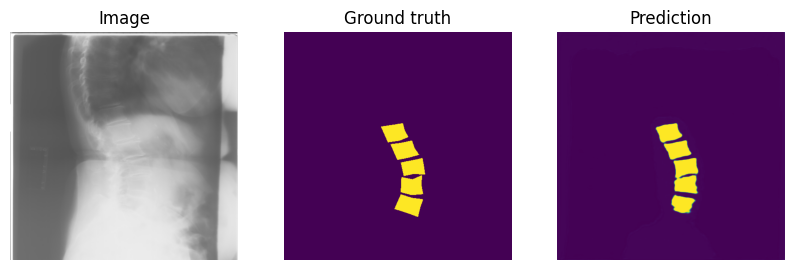

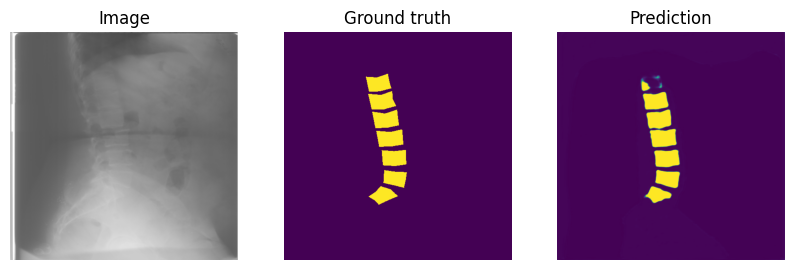

In [30]:
entrenar_modelo("lumbar")

## Obtener segmentaciones
A partir de este punto, realizo las segmentaciones y las guardo

In [18]:
def cargar_modelo(region="general"):
    """
    Carga el modelo entrenado con los datos de la región especificada.
    """
    model_result_dir = os.path.join(RESULTS_DIR, region)
    checkpoint = encontrar_archivo_mas_reciente(model_result_dir)

    if checkpoint:
      print(f'Cargando modelo desde {checkpoint}')
      model = SpineModel.load_from_checkpoint(checkpoint)
      #model.eval()
      return model
    else:
      print('No se encontraron modelos entrenados.')
      return None
    
preprocesado = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),  # Mismo preprocesado de la primera parte
    ToTensorV2()
])



In [19]:
preprocesado = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),  # Mismo preprocesado de la primera parte
    ToTensorV2()
])

# Redimensiona una imagen a múltiplo de 32
def redimensionar_imagen(image):
    if len(image.shape) == 2:  # Si es imagen en escala de grises
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convertirla a RGB
    image = np.array(Image.fromarray(image).resize((512, 512), Image.BILINEAR))  # Redimensionar a 512x512
    return image

# Preprocesa una imagen para ser utilizada en el modelo
def preprocesar_imagen(imagen):
    imagen = redimensionar_imagen(imagen)  # Redimensionar la imagen

    # Aplica el preprocesado y normalización de la imagen usando Albumentations
    augmented = preprocesado(image=imagen)
    imagen = augmented['image']  # Esta imagen ya es un tensor de PyTorch

    if imagen.shape[0] == 1:  # Si la imagen tiene un solo canal (grayscale)
        imagen = imagen.repeat(3, 1, 1)  # Convertirla a 3 canales (RGB)

    return imagen  # Devolver el tensor listo para ser usado en el modelo

In [ ]:
def predecir_imagen(model, image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  h, w = img.shape[:2]
  img_tensor = preprocesar_imagen(img)

  logits = model(img_tensor.unsqueeze(0))  # Predecir la máscara
  pr_mask = logits.sigmoid().squeeze().detach().cpu().numpy()  # Obtener la máscara y convertirla a NumPy

  pr_mask_bin = (pr_mask > 0.5).astype(np.uint8)  # Binarizar la máscara
  pr_mask_bin = cv2.resize(pr_mask_bin, (w, h), interpolation=cv2.INTER_NEAREST)  # Redimensionar la máscara
    
  return pr_mask_bin

In [21]:
def obtener_segmentaciones(model, input_path, output_path):
    print(f"Entrada: '{input_path}'")
    print(f"Salida: '{output_path}'")
    with torch.no_grad():
        for img_name in os.listdir(input_path):
            img_path = os.path.join(input_path, img_name)
            pr_mask = predecir_imagen(model, img_path)
            save_path = os.path.join(output_path, img_name)
            Image.fromarray(pr_mask).save(save_path)

In [22]:
def obtener_segmentaciones_regiones(region):
  model = cargar_modelo(region)
  if model: 
    # Para las de NHANES
    input_path_nhanes = os.path.join(DATASET_PATH, region, 'imagenes')
    output_path_nhanes = os.path.join(DATASET_PATH, region, 'segmentaciones')
    os.makedirs(output_path_nhanes, exist_ok=True)
    obtener_segmentaciones(model, input_path_nhanes, output_path_nhanes)

    print('Segmentaciones para NHANES completadas.')
    
    # Para las del médico
    input_path_med = os.path.join(NEW_DATA_PATH, region, 'imagenes')
    output_path_med = os.path.join(NEW_DATA_PATH, region, 'segmentaciones')
    os.makedirs(output_path_med, exist_ok=True)
    obtener_segmentaciones(model, input_path_med, output_path_med)

    print('Segmentaciones para las imágenes del médico completadas.')

### Modelo general

In [ ]:
region = 'general'
obtener_segmentaciones_regiones(region)


### Modelo cervical

In [ ]:
region = 'cervical'
obtener_segmentaciones_regiones(region)

### Modelo lumbar

In [ ]:
region = 'lumbar'
obtener_segmentaciones_regiones(region)